# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import hist
plt.style.use('seaborn')
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import itertools 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

# EDA

In [2]:
df_merge = pd.read_csv('merge_data.csv')
df_merge = df_merge.drop('Unnamed: 0', 1)
df_merge.head()

,publisher,author,isbn,date,title,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating
0,Riverhead,Paula Hawkins,1594634025,2017-02-19,THE GIRL ON THE TRAIN,102,5,4832,8435,417,2082071,3313269,109917,3.92
1,Scribner,Anthony Doerr,1501173219,2017-05-07,ALL THE LIGHT WE CANNOT SEE,81,6,4375,10744,565,1005586,2142471,75056,4.33
2,Vintage,E L James,0525431888,2017-03-05,FIFTY SHADES DARKER,66,3,71,155,7,737540,1064380,29077,3.84
3,St. Martin's,Kristin Hannah,1466850604,2017-10-29,THE NIGHTINGALE,63,2,631,1480,150,680040,1319418,63407,4.58
4,Penguin Group,Kathryn Stockett,1440697663,2012-04-08,THE HELP,58,2,1491,1922,330,2141308,3031266,84485,4.47


In [3]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281 entries, 0 to 1280
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   publisher                1281 non-null   object 
 1   author                   1281 non-null   object 
 2   isbn                     1281 non-null   object 
 3   date                     1281 non-null   object 
 4   title                    1281 non-null   object 
 5   weeks_on_list            1281 non-null   int64  
 6   no_of_words_title        1281 non-null   int64  
 7   ratings_count            1281 non-null   int64  
 8   reviews_count            1281 non-null   int64  
 9   text_reviews_count       1281 non-null   int64  
 10  work_ratings_count       1281 non-null   int64  
 11  work_reviews_count       1281 non-null   int64  
 12  work_text_reviews_count  1281 non-null   int64  
 13  average_rating           1281 non-null   float64
dtypes: float64(1), int64(8),

### Explore the relationships between variables

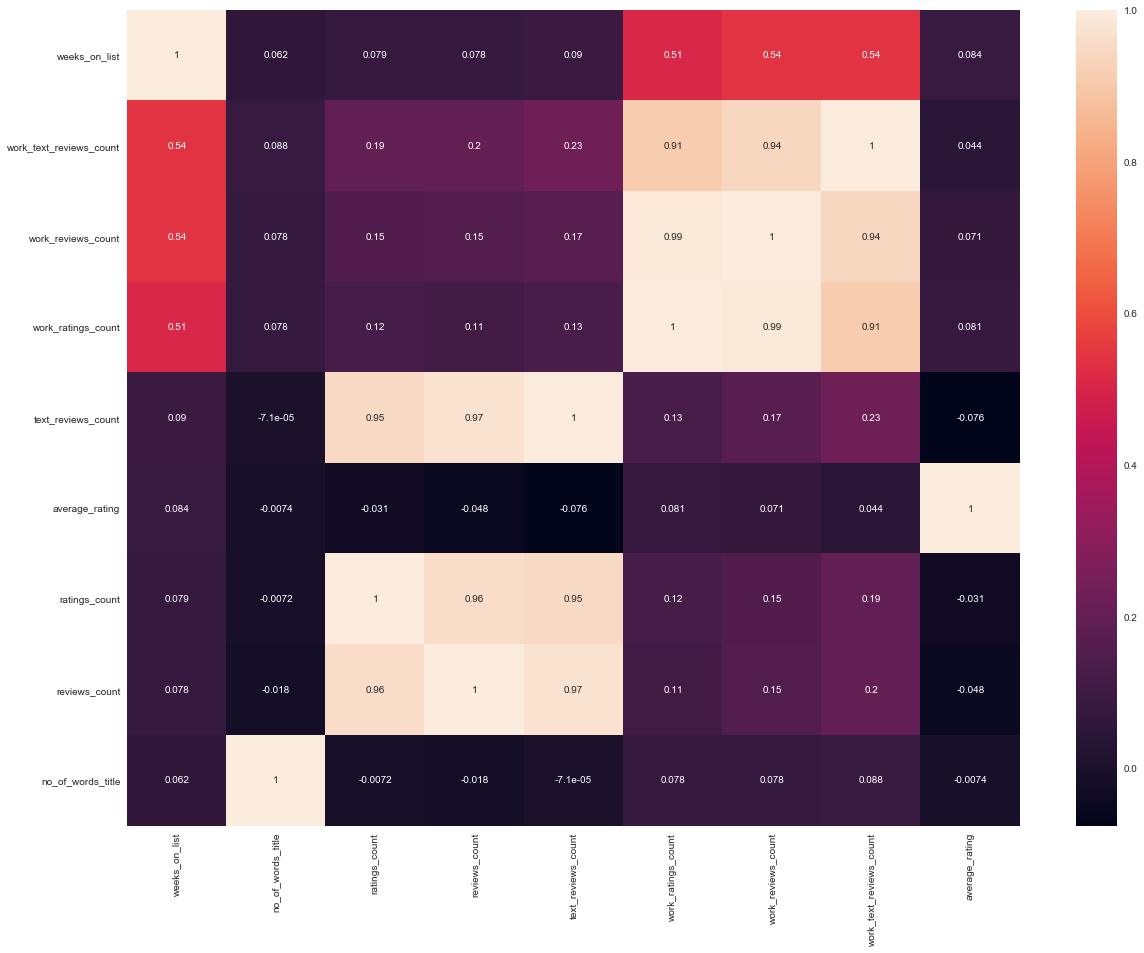

In [4]:
plt.subplots(figsize=(20,15))
sns.heatmap(df_merge.corr().sort_values('weeks_on_list', ascending=False), annot=True)
plt.show()

In [5]:
# Calculate correlation of each feature to 'weeks_on_list' and sort in descending order
corr = df_merge.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'weeks_on_list']
corr.sort_values(by = 'Correlation_Values', ascending = False)

,Target,Features,Correlation_Values
0,weeks_on_list,weeks_on_list,1.000000
7,weeks_on_list,work_text_reviews_count,0.538240
6,weeks_on_list,work_reviews_count,0.537973
5,weeks_on_list,work_ratings_count,0.509958
4,weeks_on_list,text_reviews_count,0.089506
8,weeks_on_list,average_rating,0.084384
2,weeks_on_list,ratings_count,0.078993
3,weeks_on_list,reviews_count,0.078310
1,weeks_on_list,no_of_words_title,0.061858


### Distribution of review and rating counts

(array([ 17318.07053846,  59085.1818371 , 171143.28532124, 277089.12861535,
        320893.65997733, 225134.91699997, 107983.26335745,  33617.43104524,
          8149.68025339,   2037.42006335]),
 array([-2.88542781, -2.20504476, -1.52466171, -0.84427867, -0.16389562,
         0.51648743,  1.19687048,  1.87725352,  2.55763657,  3.23801962,
         3.91840267]),
 <a list of 10 Patch objects>)

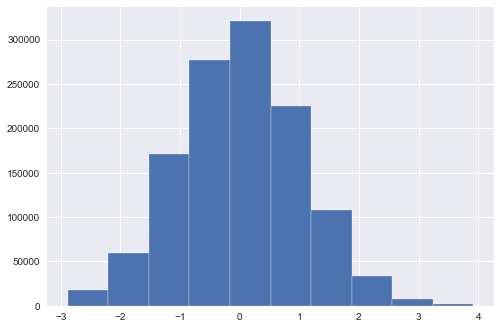

In [6]:
# Distribution of work_text_reviews_count
df = pd.DataFrame({'work_text_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_text_reviews_count, weights=df.weeks_on_list)

(array([ 1037.9473646 ,  2698.66314796, 10379.47364599, 28024.57884416,
        47122.81035278, 64767.91555096, 50236.65244658, 34667.4419776 ,
         8095.98944387,  2075.8947292 ]),
 array([-3.55589297, -2.90981047, -2.26372796, -1.61764546, -0.97156295,
        -0.32548045,  0.32060206,  0.96668456,  1.61276707,  2.25884957,
         2.90493208]),
 <a list of 10 Patch objects>)

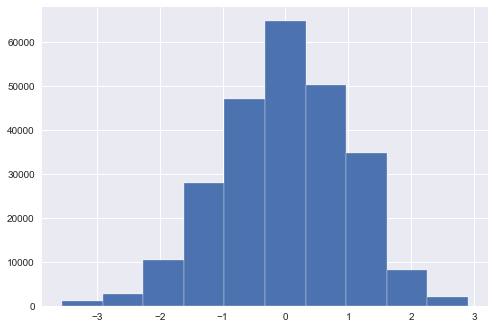

In [7]:
# Distribution of work_reviews_count
df = pd.DataFrame({'work_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_reviews_count, weights=df.weeks_on_list)

(array([  4223.51012171,  10558.77530428,  33788.0809737 , 107699.50810367,
        186538.36370897, 226661.70986523, 154158.11944251,  91509.38597044,
         22525.3873158 ,   7039.18353619]),
 array([-3.48559986, -2.82890334, -2.17220683, -1.51551032, -0.85881381,
        -0.2021173 ,  0.45457921,  1.11127572,  1.76797224,  2.42466875,
         3.08136526]),
 <a list of 10 Patch objects>)

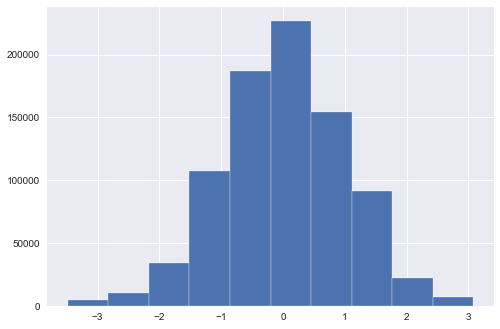

In [8]:
# Distribution of work_ratings_count
df = pd.DataFrame({'work_ratings_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.work_ratings_count, weights=df.weeks_on_list)

(array([  3167.90633427,   7919.76583567,  36430.92284409, 138595.90212424,
        216209.60731382, 229673.20923446, 194826.23955751,  80781.61152384,
         34054.99309339,   8711.74241924]),
 array([-3.52185829, -2.86403975, -2.2062212 , -1.54840265, -0.8905841 ,
        -0.23276555,  0.425053  ,  1.08287155,  1.7406901 ,  2.39850864,
         3.05632719]),
 <a list of 10 Patch objects>)

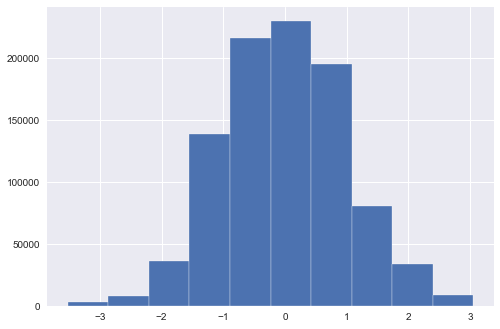

In [9]:
# Distribution of text_reviews_count
df = pd.DataFrame({'text_reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.text_reviews_count, weights=df.weeks_on_list)

(array([  1638.96521724,   6965.60217328,  29911.11521465,  64739.12608103,
        113908.08259827, 117595.75433706,  94240.49999137,  44252.06086551,
         14340.94565086,   4097.4130431 ]),
 array([-3.35355008, -2.70639063, -2.05923118, -1.41207173, -0.76491228,
        -0.11775283,  0.52940662,  1.17656607,  1.82372551,  2.47088496,
         3.11804441]),
 <a list of 10 Patch objects>)

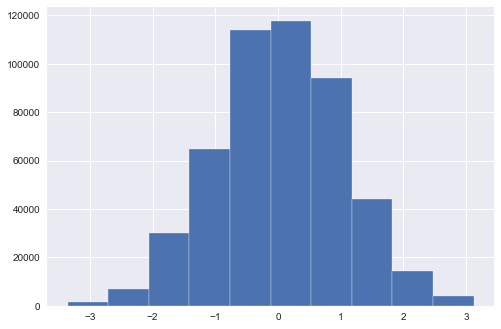

In [10]:
# Distribution of ratings_count
df = pd.DataFrame({'ratings_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.ratings_count, weights=df.weeks_on_list)

(array([  2363.30994224,  10044.06725451,  45493.71638808, 121119.63453969,
        186110.65795123, 183747.34800899, 108712.25734294,  38403.78656136,
         10634.89474007,   2363.30994224]),
 array([-3.48961596, -2.78112506, -2.07263415, -1.36414324, -0.65565233,
         0.05283858,  0.76132948,  1.46982039,  2.1783113 ,  2.88680221,
         3.59529312]),
 <a list of 10 Patch objects>)

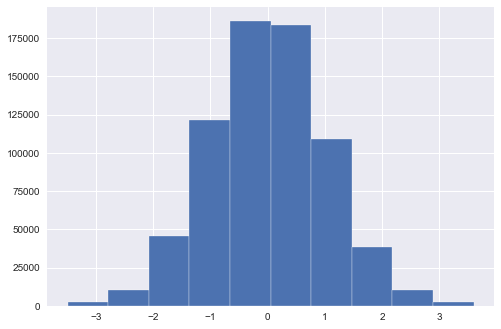

In [11]:
# Distribution of reviews_count
df = pd.DataFrame({'reviews_count': np.random.randn(1200),
                   'weeks_on_list': 1200 * np.random.rand()})
hist(df.reviews_count, weights=df.weeks_on_list)

### Scatter plots for average rating and number of words in title

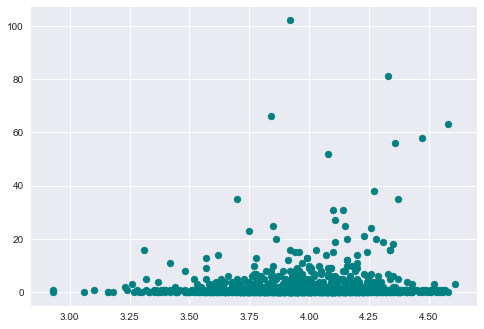

In [12]:
plt.scatter(df_merge['average_rating'], df_merge['weeks_on_list'], color='teal')

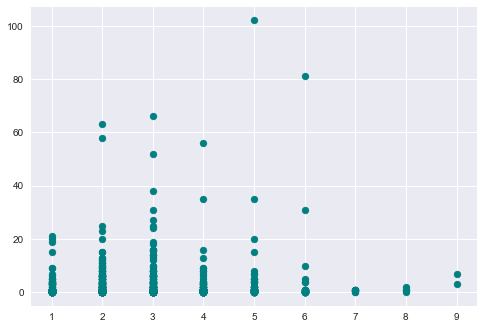

In [13]:
plt.scatter(df_merge['no_of_words_title'], df_merge['weeks_on_list'], color='teal')

### Top 20 Publishers with the most best selling books

In [14]:
publisher_list = df_merge['publisher'].to_list()

In [15]:
publisher_list

['Riverhead',
 'Scribner',
 'Vintage',
 "St. Martin's",
 'Penguin Group',
 'Washington Square',
 'Andrews McMeel',
 'Berkley',
 'Ballantine',
 'Scout',
 'Penguin Press',
 'Knopf Doubleday Publishing',
 'Houghton Mifflin Harcourt',
 'Doubleday',
 'Grand Central',
 'Broadway',
 'Doubleday',
 'Dell',
 'Andrews McMeel',
 'Doubleday',
 'Ballantine',
 'Scribner',
 'Vintage',
 'Forge Books',
 "St. Martin's",
 'Doubleday',
 'Ballantine',
 'Grand Central',
 'Harper',
 'Morrow',
 'Scribner',
 'Grand Central',
 'Grand Central',
 'Delacorte',
 'Doubleday',
 'Grand Central',
 'Riverhead',
 'Windblown Media',
 'Sarah Crichton/Farrar, Straus & Giroux',
 'Delacorte Press',
 'Grand Central',
 'Grand Central',
 'Houghton Mifflin Harcourt',
 'Delacorte',
 'Berkley',
 'Ecco/HarperCollins',
 'Grand Central',
 'Little, Brown',
 'Grand Central',
 'Putnam',
 'Knopf',
 'Knopf Doubleday',
 'Vintage',
 'Viking',
 'Flatiron',
 'Grand Central',
 'Delacorte',
 'Grand Central',
 'Grand Central',
 'Little, Brown',
 "

In [16]:
# Convert any of the iterable to sequence of iterable publishers with dintinct publishers
unique_publishers = set(publisher_list)

In [17]:
# Count the number of books for each publisher
num_publisher = {}
for publisher in unique_publishers:
    num_publisher[publisher] = publisher_list.count(publisher)
    
num_publisher

{'Pocket': 2,
 'Open Road Media': 2,
 'Morrow': 26,
 'Center Street': 3,
 'Tor/Tom Doherty': 5,
 'Harlequin HQN': 3,
 'Knopf Doubleday Publishing': 12,
 'Kensington': 8,
 'Ecco/HarperCollins': 3,
 'Sapphire Star Publishing': 1,
 'Knopf Doubleday Publishing Group': 1,
 'ROC': 2,
 "Knopf/McSweeney's": 1,
 'Grand Central': 60,
 'Silhouette': 1,
 'Henry Holt & Company': 1,
 'Penguin': 3,
 'Soho Press': 1,
 'Crown/Archetype': 2,
 "St. Martin's": 55,
 'Delacorte Press': 1,
 'Reagan Arthur/Little, Brown': 1,
 'Delacorte': 37,
 'Atlantic Monthly Press': 1,
 'Tom Doherty': 2,
 'Ace': 7,
 'Laurelin Paige': 1,
 'Broadway': 5,
 'Vintage': 8,
 'Harper': 22,
 'Penguin Group': 21,
 'Kingswell': 1,
 'Knopf': 21,
 'Algonquin': 3,
 'Harper/HarperCollins': 5,
 'Howard': 1,
 'Berkley': 20,
 'Bethany House': 1,
 'Ballatine': 1,
 'Mira': 20,
 'Signet': 4,
 'Nan A. Talese/Doubleday': 1,
 'Carina Press': 1,
 'Forever/Grand Central': 1,
 'Sarah Crichton/Farrar, Straus & Giroux': 1,
 'Dutton': 9,
 'Dial': 3,
 '

In [18]:
# Sort the publisher list from the highest to the lowest number of books
num_publisher = {k: v for k, v in sorted(num_publisher.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [19]:
# Review the list
num_publisher

{'Simon & Schuster': 69,
 'Little, Brown': 67,
 'Grand Central': 60,
 "St. Martin's": 55,
 'Putnam': 47,
 'Random House': 43,
 'Random House Publishing': 42,
 'Harlequin': 38,
 'Delacorte': 37,
 'Ballantine': 34,
 'Morrow/HarperCollins': 33,
 'HarperCollins Publishers': 32,
 'Avon': 30,
 'Morrow': 26,
 'Bantam': 25,
 'Harper': 22,
 'Scribner': 22,
 'HarperCollins': 22,
 'Penguin Group': 21,
 'Knopf': 21,
 'Atria': 21,
 'Berkley': 20,
 'Mira': 20,
 'HQN': 20,
 'Grand Central Publishing': 19,
 "St. Martin's Press": 19,
 'Del Rey': 15,
 'Doubleday': 14,
 'Little, Brown & Company': 14,
 'Minotaur': 13,
 'Knopf Doubleday Publishing': 12,
 'Zebra': 12,
 'Gallery': 11,
 'Touchstone': 11,
 'Knopf Doubleday': 11,
 'Dutton': 9,
 'Gallery Books': 9,
 'Kensington': 8,
 'Vintage': 8,
 'Ace': 7,
 'Viking': 7,
 'BookShots': 7,
 'Riverhead': 6,
 'Harlequin Mira': 6,
 'Emily Bestler/Atria': 6,
 'Tor/Tom Doherty': 5,
 'Broadway': 5,
 'Harper/HarperCollins': 5,
 'Houghton Mifflin Harcourt': 5,
 'Dell': 5

In [20]:
# Make another list with Top 20 publishers with the higest number of best selling books
publisher_20 = dict(itertools.islice(num_publisher.items(), 20))

In [21]:
publisher_20

{'Simon & Schuster': 69,
 'Little, Brown': 67,
 'Grand Central': 60,
 "St. Martin's": 55,
 'Putnam': 47,
 'Random House': 43,
 'Random House Publishing': 42,
 'Harlequin': 38,
 'Delacorte': 37,
 'Ballantine': 34,
 'Morrow/HarperCollins': 33,
 'HarperCollins Publishers': 32,
 'Avon': 30,
 'Morrow': 26,
 'Bantam': 25,
 'Harper': 22,
 'Scribner': 22,
 'HarperCollins': 22,
 'Penguin Group': 21,
 'Knopf': 21}

In [22]:
# Make 2 lists for name of publishers and number of books
publishers = []
counts = []

for publisher, count in publisher_20.items():
    publishers.append(publisher)
    counts.append(count)

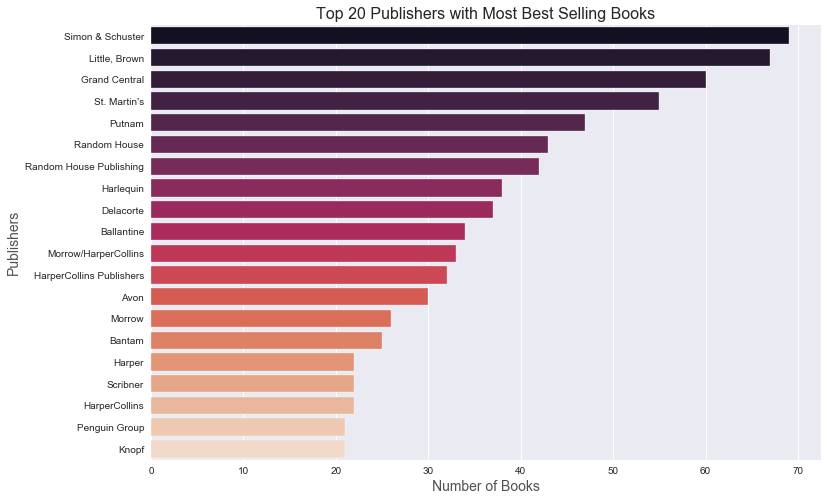

In [23]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr1 = sns.barplot(x=counts, y=publishers,
                  ci=None, palette='rocket')
gr1.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr1.set_ylabel('Publishers', fontsize=14, alpha=0.8)
gr1.set_title('Top 20 Publishers with Most Best Selling Books', fontsize=16)
plt.show()

### Top 20 Authors with the most best selling books

In [24]:
author_list = df_merge['author'].to_list()

In [25]:
# Convert any of the iterable to sequence of iterable authors with dintinct authors
unique_authors = set(author_list)

In [26]:
# Count the number of books for each author
num_author = {}
for author in unique_authors:
    num_author[author] = author_list.count(author)
    
num_author

{'Haruki Murakami': 2,
 'Drew Karpyshyn': 1,
 'Ian McGuire': 1,
 'Larissa Ione': 1,
 'Raeanne Thayne': 1,
 'Emily Giffin': 5,
 'Clive Cussler with Grant Blackwood': 1,
 'Nancy Thayer': 1,
 'Diana Palmer': 5,
 'John Irving': 4,
 'Paulo Coelho': 2,
 'RaeAnne Thayne': 3,
 'Daniel Silva': 5,
 'Lene Kaaberbol': 1,
 'Darynda Jones': 2,
 'James Luceno': 1,
 'Aaron Allston': 1,
 'Jhumpa Lahiri': 1,
 'Junot Diaz': 1,
 'James Patterson with Richard DiLallo': 1,
 'Jeanne Glidewell': 1,
 'Jessica Knoll': 1,
 'Justin Cronin': 2,
 'Anne Tyler': 1,
 'H P Mallory': 1,
 'Marc Cameron': 1,
 'Tess Gerritsen': 7,
 'Orson Scott Card': 1,
 'Anthony Ryan': 1,
 'Johanna Lindsey': 1,
 'Christopher Moore': 3,
 'Emma Cline': 1,
 'Susan Mallery': 20,
 'Joseph Finder': 1,
 'Scott Turow': 1,
 'Catherine Coulter and JT Ellison': 1,
 'William Kent Krueger': 1,
 'Ron Carr': 17,
 'Michael Chabon': 2,
 'Chad Harbach': 1,
 'Pam Jenoff': 1,
 'Troy Denning': 1,
 'Charlaine Harris': 2,
 'J P Delaney': 1,
 'Phil Klay': 1,
 '

In [27]:
# Sort the author list from the highest to the lowest number of books
num_author = {k: v for k, v in sorted(num_author.items(), key=lambda item: item[1], 
                                         reverse=True)}

In [28]:
# Review the list
num_author

{'Danielle Steel': 25,
 'Susan Mallery': 20,
 'David Baldacci': 18,
 'Ron Carr': 17,
 'Stephen King': 13,
 'J A Jance': 13,
 'Janet Evanovich': 13,
 'Debbie Macomber': 12,
 'Lee Child': 12,
 'Nora Roberts': 12,
 'Michael Connelly': 12,
 'Linda Lael Miller': 11,
 'John Grisham': 11,
 'Karen Kingsbury': 11,
 'Lisa Scottoline': 11,
 'James Patterson and Maxine Paetro': 11,
 'Iris Johansen': 11,
 'Jill Shalvis': 10,
 'Douglas Preston and Lincoln Child': 10,
 'Dean Koontz': 10,
 'Sandra Brown': 10,
 'Kristin Hannah': 9,
 'Elin Hilderbrand': 9,
 'Fern Michaels': 9,
 'Christina Lauren': 9,
 'Lynsay Sands': 9,
 'Mary Higgins Clark': 9,
 'James Patterson and Michael Ledwidge': 8,
 'Nicholas Sparks': 8,
 'Maya Banks': 8,
 'Philippa Gregory': 8,
 'James Patterson': 8,
 'Dorothea Benton Frank': 8,
 'Marie Force': 8,
 'Richard Paul Evans': 8,
 'Kresley Cole': 8,
 'Tess Gerritsen': 7,
 'Diana Gabaldon': 7,
 'Steve Berry': 7,
 'Lisa Jackson': 7,
 'Jodi Picoult': 6,
 'Jacqueline Winspear': 6,
 'James 

In [29]:
# Make another list with Top 20 authors with the higest number of best selling books
author_20 = dict(itertools.islice(num_author.items(), 20))

In [30]:
author_20

{'Danielle Steel': 25,
 'Susan Mallery': 20,
 'David Baldacci': 18,
 'Ron Carr': 17,
 'Stephen King': 13,
 'J A Jance': 13,
 'Janet Evanovich': 13,
 'Debbie Macomber': 12,
 'Lee Child': 12,
 'Nora Roberts': 12,
 'Michael Connelly': 12,
 'Linda Lael Miller': 11,
 'John Grisham': 11,
 'Karen Kingsbury': 11,
 'Lisa Scottoline': 11,
 'James Patterson and Maxine Paetro': 11,
 'Iris Johansen': 11,
 'Jill Shalvis': 10,
 'Douglas Preston and Lincoln Child': 10,
 'Dean Koontz': 10}

In [31]:
# Make 2 lists for name of publishers and number of books
authors = []
counts = []

for author, count in author_20.items():
    authors.append(author)
    counts.append(count)

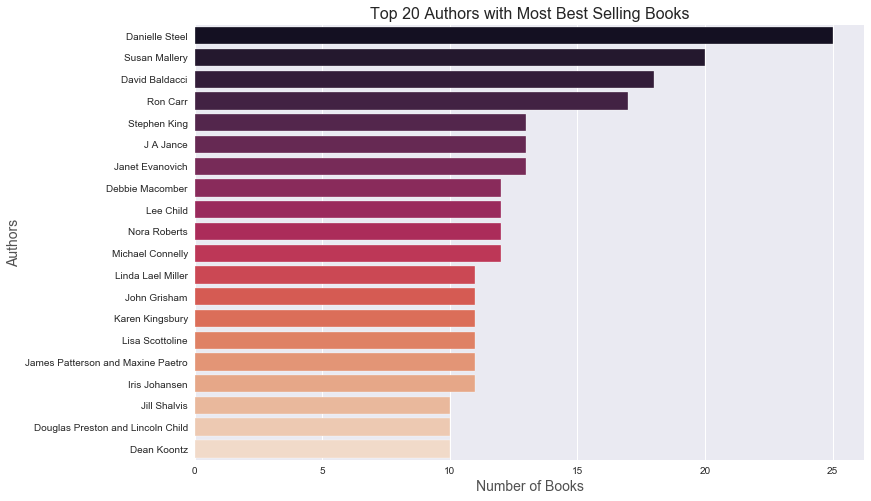

In [32]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr2 = sns.barplot(x=counts, y=authors,
                  ci=None, palette='rocket')
gr2.set_xlabel('Number of Books', fontsize=14, alpha=0.8)
gr2.set_ylabel('Authors', fontsize=14, alpha=0.8)
gr2.set_title('Top 20 Authors with Most Best Selling Books', fontsize=16)
plt.show()

### Best Sellers Trend by Years

In [33]:
# Change the format of 'date' column
df_merge['date'] = pd.to_datetime(df_merge['date'])
print(df_merge['date'].dtype)

datetime64[ns]


In [34]:
# Extract the year from 'date' column and put it in a new column 'year'
df_merge['year'] = pd.DatetimeIndex(df_merge['date']).year
df_merge.head()

,publisher,author,isbn,date,title,weeks_on_list,no_of_words_title,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count,average_rating,year
0,Riverhead,Paula Hawkins,1594634025,2017-02-19,THE GIRL ON THE TRAIN,102,5,4832,8435,417,2082071,3313269,109917,3.92,2017
1,Scribner,Anthony Doerr,1501173219,2017-05-07,ALL THE LIGHT WE CANNOT SEE,81,6,4375,10744,565,1005586,2142471,75056,4.33,2017
2,Vintage,E L James,0525431888,2017-03-05,FIFTY SHADES DARKER,66,3,71,155,7,737540,1064380,29077,3.84,2017
3,St. Martin's,Kristin Hannah,1466850604,2017-10-29,THE NIGHTINGALE,63,2,631,1480,150,680040,1319418,63407,4.58,2017
4,Penguin Group,Kathryn Stockett,1440697663,2012-04-08,THE HELP,58,2,1491,1922,330,2141308,3031266,84485,4.47,2012


In [35]:
yr_list = df_merge['year'].to_list()

In [36]:
# Convert any of the iterable to sequence of iterable years with dintinct years
unique_yrs = set(yr_list)

In [37]:
# Count the number of books for each year
num_yr = {}
for yr in unique_yrs:
    num_yr[yr] = yr_list.count(yr)

In [40]:
# Sort the year list in order of 2011 to 2018
num_yr = dict(sorted(list(num_yr.items())))
num_yr

{2011: 149,
 2012: 142,
 2013: 136,
 2014: 145,
 2015: 178,
 2016: 255,
 2017: 188,
 2018: 88}

In [41]:
# Make 2 lists for years and number of books
yrs = []
counts = []

for yr, count in num_yr.items():
    yrs.append(yr)
    counts.append(count)

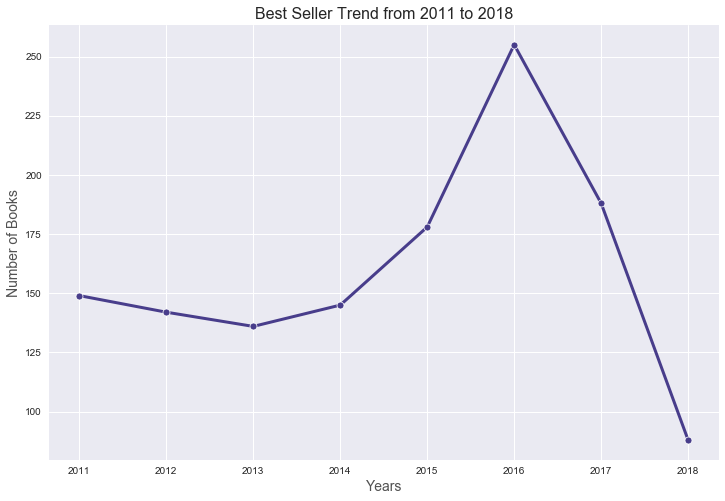

In [59]:
# Graph to see the trend
plt.figure(figsize=(12, 8))
gr3 = sns.lineplot(yrs, counts, ci=None, marker='o', color='darkslateblue', linewidth=3)
gr3.set_ylabel('Number of Books', fontsize=14, alpha=0.8)
gr3.set_xlabel('Years', fontsize=14, alpha=0.8)
gr3.set_title('Best Seller Trend from 2011 to 2018', fontsize=16)
plt.show()